<h1 align=center> <b>SwarmPy</b> </h1>

<p align="center">
<a href="https://www.python.org/downloads/release/python-3100/" 
target="_blank"><img src="https://img.shields.io/badge/python-3.10-blue.svg" alt="Python Version" /></a>
<img src="https://img.shields.io/github/license/g0bel1n/TinyAutoML?style=flat-square" alt="Licence MIT" />
</p>

---

<p align="center">
SwarmPy is an experimental library. <br/>
It aims at providing a modulable framework to test and experiment on Ant Colony Optimzation (ACO) algorithms on Travelling Salesman Problem<br/>
contact : lucas.saban[at]ensae.fr
</p>


---

## ⚡️ Quick start 

First let's import the librairies we will use

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
os.chdir('..')

from swarmpy_tsp import *


The `ant_coder` function can load the TSP test sets of the test_set folder, namely :
- berlin52 
- ch130
- Any test set you wish, as long you add them to folder following the same format.

`G` is the graph representation of the problem. Its a dictionnary containing a uninitialized pheromone matrix, a heuristics matrix and a cost matrix

In [2]:
G, opt_score = Antcoder('test_set/berlin52')

Ant colony optmization algorithms can be built in the same fashion as a Pipeline object from `scikit-learn`. You only need to put the blocks in the right order.

> Careful ! The G dictionnary is modified inplace during computation. If you want to try different run with the same datapoints, you shall use `deepcopy` from the `copy` built-in library.

Below, you can see an example of an ACO Pipeline

In [3]:
aco_pipeline = ACO_Pipeline(
    [
        ("Planner", Planner({"alpha": 1.0, "beta": 2.0})),
        ("Sol", SolutionConstructor()),
        ("DA", DaemonActions()),
        ("Updater", BestTourPheromonesUpdater()),

    ], 
    iter_max=60
)

An `ACO_Pipeline` is composed by objects inhering from the **semi abstract** class `ACO_Step`. Those steps are more or less the main composants of any ACO Algorithms and are independently built so that one can use them in other situations or can easily build new blocks.
Let's dive in !

## The `ACO_Steps`

### `Planner`
First of all, there is the `Planner` step. In very basic use cases, it is not really important and only serves as the place to define your ants parameters. In more advanced cases, such as **iteration-dependent ants parameters**, that's where the magic happen.

The `Planner` object have one parameter which is a `dict` of those parameters :

-   `alpha`: coefficient associated to the **pheromone trails**
-   `beta`: coefficient associated to the **heuristic information**
-   `q`: Corresponds to the **level of exploitation** in Ant Colony System. When not precised, it is set to 0 which is equivalent to Ant System
-   `mask`: Corresponds to a **mask applied on the graph**. It is useful when you want to reduce your problem to a subset of cities. If not precized, a generic all covering mask is set.

*If you are not familliar with those notations please refer to appropriate ACO litterature (Dorigo, Stützle, ...)*

The `RandomizedPlanner` object, which inheritates from the `Planner`, **introduces random sampling** of ants parameters. It have two more parameters, `alpha_bounds` and `beta_bounds` which are the bounds of the uniform distribution from which each ant parameters is drawn. 

> To add *iteration-dependant ant parameters*, I'd recommend to inheritate from `Planner` ant induce mutations in the `run` method which takes the iteration number as argument.

An example of instanciation : 

> To keep a parameter constant with `RandomizedPlanner`, setting low_bound = high_bound does the job

In [4]:
planner_step = RandomizedPlanner(alpha_bounds=[1.0, 1.0], beta_bounds=[1., 6.], ant_params={'q':0.8})

### The `SolutionConstructor`

The `SolutionConstructor` step is at the core of ACO. It is where ants are actually **going through the graph** to build feasible solutions. No parameters are required. 
For now, ants are running concurrently, using the `thread` built-in library of Python. Parallel computation should arrive soon.
It should be remarked that solution are sorted by descending quality.
An example of instanciation : 

In [5]:
construction_step = SolutionConstructor()

### `DaemonActions`

If the first steps are kind of necessary, this one can totally be exempted from the pipeline. It implements a **2-opt local search** on the solutions built during the construction step.
It as one parameter, `k`, that is the number of best solutions that shall go through local search. 

An example of instanciation : 

In [6]:
daemon_step = DaemonActions(k=2)

### `PheromonesUpdaters`

It's the final step of an ACO algorithm iteration. It **evaporates** pheromones and **reinforces** pheromone trails according the solutions found. 
General parameters are : 
-   `rho` : the evaporation rate (can be set to 0 for no evaporation)
-   `Q` : The normalization parameter of the pheromone reinforcement update (Q/cost)
-   `bounds` : if precised, it implements MMAS policy of bounding pheromone trails

Then there is **3 Updaters** that inherits from the abstract **base Updater** :
- `ProportionnalPheromonesUpdater` : basic updater, reinforcement in Q/cost for all solutions
- `BestSoFarPheromonesUpdater` : Reinforces the `k` best paths found so far
- `BestTourPheromonesUpdater`: Reinforces the `k` best paths found in the current lap

Those steps can totally be combined or made iteration-dependant by inheritance.

An example of instanciation : 

In [7]:
ph_updater = BestTourPheromonesUpdater(k=2, bounds=[0.1, 1])

___

## Now you can play with it !

The ACO_Pipeline object return the list of all solutions built during computation

SwarmPy | Score : 7859.448968094198: 100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


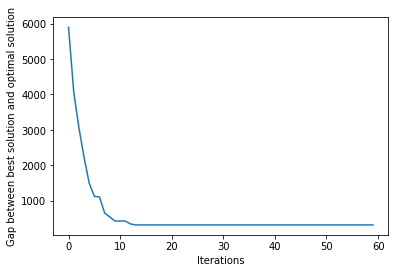

In [8]:
solutions_w_daemon = aco_pipeline.run(G=G)
scores_w_daemon = np.array([el[1] for el in solutions_w_daemon['solutions']]) - opt_score

plt.plot(scores_w_daemon)
plt.xlabel('Iterations')
plt.ylabel('Gap between best solution and optimal solution')
plt.show()

**For an advanced example of combining Pipelines, please refer to the advanced_swarmpy notebook**